# Notebook to create a Drug-Variant Matrix including all OPRM drugs

For this notebook you need previously to run:

1) WGS_variants_identification_2.ipynb  

2) variants_eid.sh 

in the UK Biobank RAP to obtain the filtered_variants_per_eid.raw and the OPRM1_missense_variants.annotations files with OPRM1 missense variants 

## Obtain eids per drug

Using omop drug era database

In [1]:
import pyspark
import dxpy
import dxdata
from pyspark.sql.functions import col, to_date

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

First obtain the drug id with drug_era_atc.tsv table and the atc_dict.py to obtain the ATC of each drug.

In [ ]:
# Load the table
df_ATC = pd.read_csv("mappings/drug_era/drug_era_atc.tsv", sep="\t")

# Convert concept_name and drugs_to_filter to lowercase for case-insensitive filtering
df_ATC["concept_name_lower"] = df_ATC["concept_name"].str.lower()

# List of drugs to filter
drugs_to_filter = [
    "Loperamide",
    "Morphine",
    "Methadone",
    "Fentanyl",
    "Sufentanil",
    "3-Methylfentanyl",
    "3-Methylthiofentanyl",
    "Alfentanil",
    "Alvimopan",
    "Amisulpride",
    "Amitriptyline",
    "Anileridine",
    "Aripiprazole",
    "Buprenorphine",
    "Butorphanol",
    "Butyrfentanyl",
    "Cannabidiol",
    "Carfentanil",
    "Codeine",
    "Dextromethorphan",
    "Dextropropoxyphene",
    "Dezocine",
    "Diamorphine",
    "Dihydromorphine",
    "Dimethylthiambutene",
    "Diphenoxylate",
    "Diprenorphine",
    "Eluxadoline",
    "Epicept Np-1",
    "Ethylmorphine",
    "Etorphine",
    "Hydrocodone",
    "Hydromorphone",
    "Ketamine",
    "Ketobemidone",
    "Li-301",
    "Levacetylmethadol",
    "Levallorphan",
    "Levorphanol",
    "Loxicodegol",
    "Cannabis",
    "Meperidine",
    "Metenkefalin",
    "Methadyl Acetate",
    "Methylnaltrexone",
    "Morphine Glucuronide",
    "Nabiximols",
    "Nalbuphine",
    "Naldemedine",
    "Nalmefene",
    "Naloxegol",
    "Naloxone",
    "Naltrexone",
    "Oliceridine",
    "Ondansetron",
    "Opium",
    "Oxycodone",
    "Oxymorphone",
    "Pentazocine",
    "Pentoxyverine",
    "Pholcodine",
    "Remifentanil",
    "Samidorphan",
    "Tapentadol",
    "Tianeptine",
    "Tramadol",
    "Trimebutine",
    "V1003",
]
drugs_to_filter_lower = {drug.lower() for drug in drugs_to_filter}

# Filter rows where the lowercase drug name is in the lowercase list of drugs to filter
filtered_df_ATC = df_ATC[df_ATC["concept_name"].isin(drugs_to_filter_lower)]

# Identify drugs that do not appear in the dataframe
missing_drugs = drugs_to_filter_lower - set(df_ATC["concept_name_lower"])

# Print a message if there are missing drugs
if missing_drugs:
    print(
        f"The following drugs were not found in the dataset: {', '.join(missing_drugs)}"
    )

# Drop the temporary lowercase column to keep the original dataframe clean
df_ATC.drop(columns=["concept_name_lower"], inplace=True)

# Select the required columns and rename _c13 to ATC
filtered_df_ATC = filtered_df_ATC[
    [
        "drug_concept_id",
        "concept_name",
        "domain_id",
        "concept_class_id",
        "concept_code",
        "valid_start_date",
        "valid_end_date",
        "invalid_reason",
        "_c13",
    ]
]

# Rename the _c13 column to ATC
filtered_df_ATC.rename(columns={"_c13": "ATC"}, inplace=True)

display(filtered_df_ATC)

The following drugs were not found in the dataset: eluxadoline, tianeptine, alvimopan, 3-methylfentanyl, oliceridine, levorphanol, nabiximols, diprenorphine, oxymorphone, morphine glucuronide, li-301, diamorphine, levacetylmethadol, opium, metenkefalin, dextropropoxyphene, dezocine, loxicodegol, methadyl acetate, hydrocodone, epicept np-1, etorphine, carfentanil, ketobemidone, v1003, sufentanil, naldemedine, cannabis, samidorphan, dimethylthiambutene, nalbuphine, trimebutine, butyrfentanyl, butorphanol, dihydromorphine, ethylmorphine, remifentanil, methylnaltrexone, levallorphan, pentoxyverine, anileridine, 3-methylthiofentanyl


,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC
52,930916,diphenoxylate,Drug,Ingredient,3500,1970-01-01,2099-12-31,NaN,A07DA01
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03
99,1102527,meperidine,Drug,Ingredient,6754,1970-01-01,2099-12-31,NaN,N02AB02
101,1103640,methadone,Drug,Ingredient,6813,1970-01-01,2099-12-31,NaN,N07BC02
271,757688,aripiprazole,Drug,Ingredient,89013,1970-01-01,2099-12-31,NaN,N05AX12
322,45774613,naloxegol,Drug,Ingredient,1551777,2014-12-01,2099-12-31,NaN,A06AH03
334,710062,amitriptyline,Drug,Ingredient,704,1970-01-01,2099-12-31,NaN,N06AA09
418,785649,ketamine,Drug,Ingredient,6130,1970-01-01,2099-12-31,NaN,N01AX03
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03


In [ ]:
# Import the ATC dictionaries from atc_dict.py (look in which directory it is located)
from src.project_permed.atc_dict import atc_1st_level, atc_2nd_level

# Map first level ATC codes
filtered_df_ATC["ATC_First_Level"] = filtered_df_ATC["ATC"].apply(
    lambda x: x[0] if isinstance(x, str) else None
)
filtered_df_ATC["ATC_Second_Level"] = filtered_df_ATC["ATC"].apply(
    lambda x: x[:3] if isinstance(x, str) else None
)

# Map the names of the first and second level ATC categories using the imported dictionaries
filtered_df_ATC["First_Level_Name"] = filtered_df_ATC["ATC_First_Level"].map(
    atc_1st_level
)
filtered_df_ATC["Second_Level_Name"] = filtered_df_ATC["ATC_Second_Level"].map(
    lambda x: atc_2nd_level.get(x[0], {}).get(x, "Unknown")
)

filtered_df_ATC

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC,ATC_First_Level,ATC_Second_Level,First_Level_Name,Second_Level_Name
52,930916,diphenoxylate,Drug,Ingredient,3500,1970-01-01,2099-12-31,NaN,A07DA01,A,A07,Alimentary Tract and Metabolism,"Antidiarrheals, Intestinal Anti-inflammatory/A..."
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01,N,N01,Nervous System,Anesthetics
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03,N,N02,Nervous System,Analgesics
99,1102527,meperidine,Drug,Ingredient,6754,1970-01-01,2099-12-31,NaN,N02AB02,N,N02,Nervous System,Analgesics
101,1103640,methadone,Drug,Ingredient,6813,1970-01-01,2099-12-31,NaN,N07BC02,N,N07,Nervous System,Other Nervous System Drugs
271,757688,aripiprazole,Drug,Ingredient,89013,1970-01-01,2099-12-31,NaN,N05AX12,N,N05,Nervous System,Psycholeptics
322,45774613,naloxegol,Drug,Ingredient,1551777,2014-12-01,2099-12-31,NaN,A06AH03,A,A06,Alimentary Tract and Metabolism,Drugs for Constipation
334,710062,amitriptyline,Drug,Ingredient,704,1970-01-01,2099-12-31,NaN,N06AA09,N,N06,Nervous System,Psychoanaleptics
418,785649,ketamine,Drug,Ingredient,6130,1970-01-01,2099-12-31,NaN,N01AX03,N,N01,Nervous System,Anesthetics
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03,A,A07,Alimentary Tract and Metabolism,"Antidiarrheals, Intestinal Anti-inflammatory/A..."


In [4]:
# Save the filtered table to a new file
filtered_df_ATC.to_csv("filtered_drug_atc.tsv", sep="\t", index=False)

Now we can obtain the omop data bases from UK Biobank and filter for the drugs ids of interest

In [5]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

dispensed_database_name = dxpy.find_one_data_object(
    classname="database", name="app*", folder="/", name_mode="glob", describe=True
)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(
    typename="Dataset", name="app*.dataset", folder="/", name_mode="glob"
)["id"]

spark.sql("USE " + dispensed_database_name)

dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [6]:
# Init pyspark and load dataframe
# Load the 'omop_drug_era' table
omop_drug_era = "omop_drug_era"

# Load table
drug_era = dataset[omop_drug_era]

# Extract all field names from the table
field_names_era = [f.name for f in drug_era.fields]

# Retrieve the fields
df_era = drug_era.retrieve_fields(names=field_names_era, engine=dxdata.connect())

print(df_era.columns)

print(f"Number of entries era {df_era.count()}")
df_era.drop("eid").show(3, truncate=False)

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


['eid', 'drug_era_id', 'drug_concept_id', 'drug_era_start_date', 'drug_era_end_date', 'drug_exposure_count', 'gap_days']
Number of entries era 19959413
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|1236950609195|19005129       |12/05/2014         |10/06/2014       |1                  |0       |
|798863919105 |743670         |30/03/2011         |02/09/2011       |5                  |12      |
|721554547993 |19008994       |12/10/2010         |07/11/2010       |1                  |0       |
+-------------+---------------+-------------------+-----------------+-------------------+--------+
only showing top 3 rows



In [7]:
# Load the `filtered_drug_atc.tsv` file as a Pandas DataFrame
drug_mapping_df = pd.read_csv("filtered_drug_atc.tsv", sep="\t")
# Extract `drug_concept_id` values as a list
drug_concept_ids = drug_mapping_df["drug_concept_id"].dropna().unique().tolist()
drug_concept_ids

[930916,
 1154029,
 1102527,
 1103640,
 757688,
 45774613,
 710062,
 785649,
 991876,
 1714319,
 1000560,
 19014158,
 19024213,
 19026459,
 1133201,
 1103314,
 19057607,
 19059528,
 1114220,
 1130585,
 1510417,
 1201620,
 1119510,
 1126658,
 1110410,
 1124957]

In [8]:
# Filter the OMOP dataset for relevant drug_concept_id
filtered_df_era = df_era.filter(col("drug_concept_id").isin(drug_concept_ids))
# Format date columns
filtered_df_era = filtered_df_era.withColumn(
    "drug_era_start_date", to_date(col("drug_era_start_date"), "dd/MM/yyyy")
).withColumn("drug_era_end_date", to_date(col("drug_era_end_date"), "dd/MM/yyyy"))

# Show the result of the filter
filtered_df_era.drop("eid").show(truncate=False)
filtered_df_era.count()

+-------------+---------------+-------------------+-----------------+-------------------+--------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|523986031867 |1201620        |2005-01-04         |2005-02-02       |1                  |0       |
|1194000909628|1133201        |1993-08-20         |1993-10-26       |2                  |9       |
|704374697810 |1201620        |2008-07-29         |2008-10-17       |2                  |22      |
|68719563134  |710062         |1996-11-11         |1996-11-20       |1                  |0       |
|1236950640019|710062         |2010-07-20         |2010-07-29       |1                  |0       |
|575525667834 |1201620        |2015-05-28         |2015-06-26       |1                  |0       |
|781684097755 |1201620        |2009-12-24         |2010-01-07       |1                  |0       |
|300647715

869262

In [9]:
# Convert the filtered Spark DataFrame to a Pandas DataFrame
pandas_df_era = filtered_df_era.toPandas()
pandas_df_era.loc[:, "drug_concept_id"] = pandas_df_era.loc[
    :, "drug_concept_id"
].astype(int)
# Merge pandas_df_era with drug_mapping_df on `drug_concept_id`
pandas_df_era = pandas_df_era.merge(
    drug_mapping_df[["drug_concept_id", "concept_name"]],  # Only keep necessary columns
    on="drug_concept_id",
    how="left",
)
# Rename the 'concept_name' column to 'drug'
pandas_df_era.rename(columns={"concept_name": "drug"}, inplace=True)

# Save the Pandas DataFrame to a CSV file
pandas_df_era.to_csv("filtered_data_era.csv", index=False)

In [10]:
display(pandas_df_era.drop("eid", axis=1))

,drug_era_id,drug_concept_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,drug
0,523986031867,1201620,2005-01-04,2005-02-02,1,0,codeine
1,1194000909628,1133201,1993-08-20,1993-10-26,2,9,buprenorphine
2,1194000909628,1133201,1993-08-20,1993-10-26,2,9,buprenorphine
3,704374697810,1201620,2008-07-29,2008-10-17,2,22,codeine
4,68719563134,710062,1996-11-11,1996-11-20,1,0,amitriptyline
...,...,...,...,...,...,...,...
879545,687194840699,1201620,2016-06-23,2016-07-22,1,0,codeine
879546,60129577990,710062,2000-05-24,2000-06-19,1,0,amitriptyline
879547,1133871369005,710062,2000-02-25,2000-08-30,7,38,amitriptyline
879548,103079245389,710062,2014-04-29,2014-05-28,1,0,amitriptyline


                drug   count
6            codeine  102314
2      amitriptyline   45504
25          tramadol   33341
12        loperamide   15660
23        pholcodine    9616
15          morphine    7217
4      buprenorphine    3469
8      diphenoxylate    2311
21         oxycodone    2224
9           fentanyl    1684
20       ondansetron     976
13        meperidine     311
3       aripiprazole     295
18          naloxone     178
1        amisulpride     161
24        tapentadol     123
14         methadone      82
19        naltrexone      50
22       pentazocine      36
10     hydromorphone      28
7   dextromethorphan      25
11          ketamine      21
0         alfentanil      20
16         nalmefene      14
5        cannabidiol      10
17         naloxegol       2


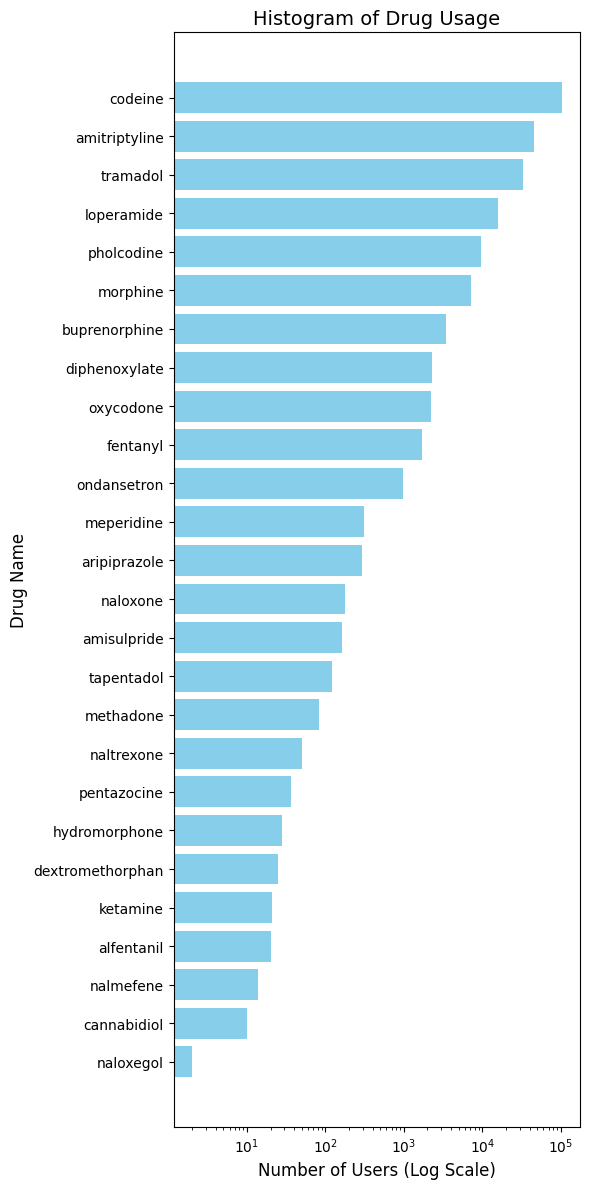

In [11]:
# Create the histogram
plt.figure(figsize=(6, 12))  # Adjust figure size for vertical layout
eid_counts = pandas_df_era.groupby(["eid", "drug"]).size().reset_index(name="count")
drug_counts = eid_counts.groupby("drug").size().reset_index(name="count")

# Sort for better visualization
drug_counts = drug_counts.sort_values(by="count", ascending=False)

print(drug_counts)

# Create a vertical bar plot with log-scale y-axis
plt.barh(drug_counts["drug"], drug_counts["count"], color="skyblue")
plt.xlabel("Number of Users (Log Scale)", fontsize=12)
plt.ylabel("Drug Name", fontsize=12)
plt.title("Histogram of Drug Usage", fontsize=14)
plt.xscale("log")  # Set x-axis to logarithmic scale
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().invert_yaxis()  # Invert y-axis to keep highest counts on top
plt.tight_layout()

# Save the plot as an image file
plt.savefig("drug_usage_histogram.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

Now lets obtain the list of EIDs per drug in a good format for the later construction of the matrix

In [12]:
# Group by 'drug' and aggregate EIDs into a list
drug_eid_df = pandas_df_era.groupby("drug")["eid"].apply(list).reset_index()

# Rename columns for clarity
drug_eid_df.columns = ["Drug", "EIDs"]

# Save the output (optional)
drug_eid_df.to_csv("drug_eid_list.csv", index=False)

## Obtain eids per variant

In [13]:
!dx download "500k WGS:/WGS_Lucia/WGS_QC/Output/Drug_variant_matrix/filtered_variants_per_eid.raw"

[===========================================================>] Completed 233,993,049 of 233,993,049 bytes (100%) /opt/notebooks/filtered_variants_per_eid.raww


In [ ]:
# Load the PLINK output file (tab-separated) with the eids and variants of interest
file_path = "filtered_variants_per_eid.raw"  # Replace with actual file path
df = pd.read_csv(file_path, sep="\t", dtype={"IID": str})

# Extract the EID (IID) column and the variant columns (everything after the 6th column)
eid_column = "IID"
variant_columns = df.columns[
    6:
]  # Ignore first 6 columns (FID, IID, PAT, MAT, SEX, PHENOTYPE)


# Function to clean variant names by removing the extra _A, _C, _G, _T
def clean_variant_name(variant):
    return re.sub(r"_[ACGT]+$", "", variant)  # Removes _A, _C, _G, _T


# Create a dictionary to store variants and their corresponding EIDs
variant_to_eids = {}

# Iterate over each row in the DataFrame
for _, row in df.iterrows():
    eid = row[eid_column]  # Get the EID
    for var in variant_columns:
        genotype = row[var]  # Get genotype value (0, 1, or 2)
        if genotype != 2:  # Only keep non-reference variants (1 or 2)
            clean_var = clean_variant_name(var)  # Clean the variant name
            if clean_var not in variant_to_eids:
                variant_to_eids[clean_var] = []  # Initialize list
            variant_to_eids[clean_var].append(eid)  # Add EID to the variant

# Convert dictionary to DataFrame
variant_eid_df = pd.DataFrame(
    list(variant_to_eids.items()), columns=["Variant", "EIDs"]
)

# Ensure unique EIDs per variant
variant_eid_df["EIDs"] = variant_eid_df["EIDs"].apply(lambda x: list(set(x)))

In [15]:
!dx download "500k WGS:/WGS_Lucia/WGS_QC/Output/Drug_variant_matrix/OPRM1_missense_variants.annotations"

[===========================================================>] Completed 7,029 of 7,029 bytes (100%) /opt/notebooks/OPRM1_missense_variants.annotationss


In [ ]:
# List of variants of interest
variants_of_interest = [
    "G255E",
    "C192F",
    "M205T",
    "N152D",
    "S147C",
    "M74T",
    "R181C",
    "A104D",
    "N190K",
    "T155I",
]

# Load the annotation file
annotation_df = pd.read_csv(
    "OPRM1_missense_variants.annotations",
    sep="\t",
    header=None,
    names=["Variant", "Gene", "Annotation"],
)

# Check which variants of interest are in the annotation file
variants_in_annotation = annotation_df["Annotation"].unique()

# Find variants of interest that are not in the annotation file
missing_variants = [
    variant for variant in variants_of_interest if variant not in variants_in_annotation
]

# Print a message if there are missing variants
if missing_variants:
    print("The following variants are not present in the annotation file:")
    print(", ".join(missing_variants))
else:
    print("All variants of interest are present in the annotation file.")

# Filter the annotation file to keep only the variants of interest that are present
filtered_annotation_df = annotation_df[
    annotation_df["Annotation"].isin(variants_of_interest)
]


# Merge dataframes on the 'Variant' column, keeping only variants that are present in both dataframes
variant_eid_df_filtered = variant_eid_df.merge(
    filtered_annotation_df[["Variant", "Annotation"]], on="Variant", how="inner"
)

# Reorder columns to place 'Annotation' as the second column
variant_eid_df_filtered = variant_eid_df_filtered[["Variant", "Annotation", "EIDs"]]

# Save the output
variant_eid_df_filtered.to_csv("variant_eid_list_filtered.csv", sep="\t", index=False)

All variants of interest are present in the annotation file.


In [17]:
display(drug_eid_df)

,Drug,EIDs
0,alfentanil,"[2796782, 1805604, 4550443, 4054527, 4773185, ..."
1,amisulpride,"[3306716, 3566356, 3566356, 3566356, 1698510, ..."
2,amitriptyline,"[2225192, 5051669, 4538760, 3653264, 5226319, ..."
3,aripiprazole,"[4185642, 4185642, 4591004, 5747609, 4038999, ..."
4,buprenorphine,"[3819377, 3819377, 2066984, 2066984, 2991689, ..."
5,cannabidiol,"[2284717, 3295817, 3295817, 5397775, 5397775, ..."
6,codeine,"[2497074, 1336550, 5864912, 4280095, 3370243, ..."
7,dextromethorphan,"[3773508, 2030929, 4200010, 5754972, 5754972, ..."
8,diphenoxylate,"[1088602, 1088602, 1088602, 1088602, 1088602, ..."
9,fentanyl,"[1463820, 1463820, 4054321, 4054321, 2186654, ..."


In [18]:
display(variant_eid_df_filtered)

,Variant,Annotation,EIDs
0,chr6:154089975:C:G,S147C,"[4686442, 1884634, 4540060, 2597040, 1164125, ..."
1,chr6:154090110:G:T,C192F,"[5712599, 3238881, 3179657, 4364932, 2489791, ..."
2,chr6:154090076:C:T,R181C,"[1363971, 3266593, 1523599, 1243159, 1277945, ..."
3,chr6:154089989:A:G,N152D,"[1543691, 2632948, 4345111, 5271658, 1684507, ..."
4,chr6:154090149:T:C,M205T,"[4289649, 1110746, 4281913, 3707027, 1690459, ..."
5,chr6:154089999:C:T,T155I,"[3546720, 1271770, 3167939, 3869427, 2335437, ..."
6,chr6:154091072:G:A,G255E,"[1372255, 3662713, 4046104, 1862397, 5577494, ..."
7,chr6:154089846:C:A,A104D,"[2158148, 3541427, 5209178, 3447135, 3889098, ..."
8,chr6:154090105:T:A,N190K,"[4465468, 2920600, 2544770, 2622126, 1266536, ..."
9,chr6:154039765:T:C,M74T,"[4555850, 3058610, 3063987]"


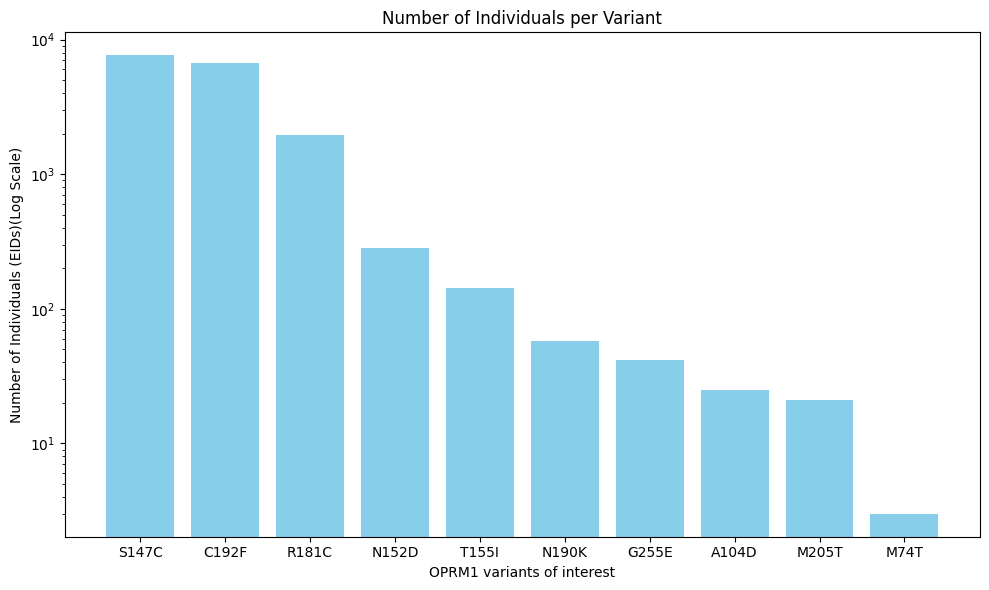

In [ ]:
# Count the number of individuals per variant
variant_eid_df_filtered["Num_Individuals"] = variant_eid_df_filtered["EIDs"].apply(len)

# Sort variants base on frequency
variant_eid_df_filtered = variant_eid_df_filtered.sort_values(
    by="Num_Individuals", ascending=False
)

# Print the number of individuals per variant
print("Variant | Number of Individuals")
print("--------------------------------")
for index, row in variant_eid_df_filtered.iterrows():
    print(f"{row['Annotation']} | {row['Num_Individuals']}")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(
    variant_eid_df_filtered["Annotation"],
    variant_eid_df_filtered["Num_Individuals"],
    color="skyblue",
)

# Formatting
plt.xlabel("OPRM1 variants of interest")
plt.ylabel("Number of Individuals (EIDs)(Log Scale)")
plt.title("Number of Individuals per Variant")
plt.yscale("log")  # Set x-axis to logarithmic scale
plt.tight_layout()

# Save the plot as an image file
plt.savefig("OPRM1_variants_histogram.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

## Creation of the Matrix

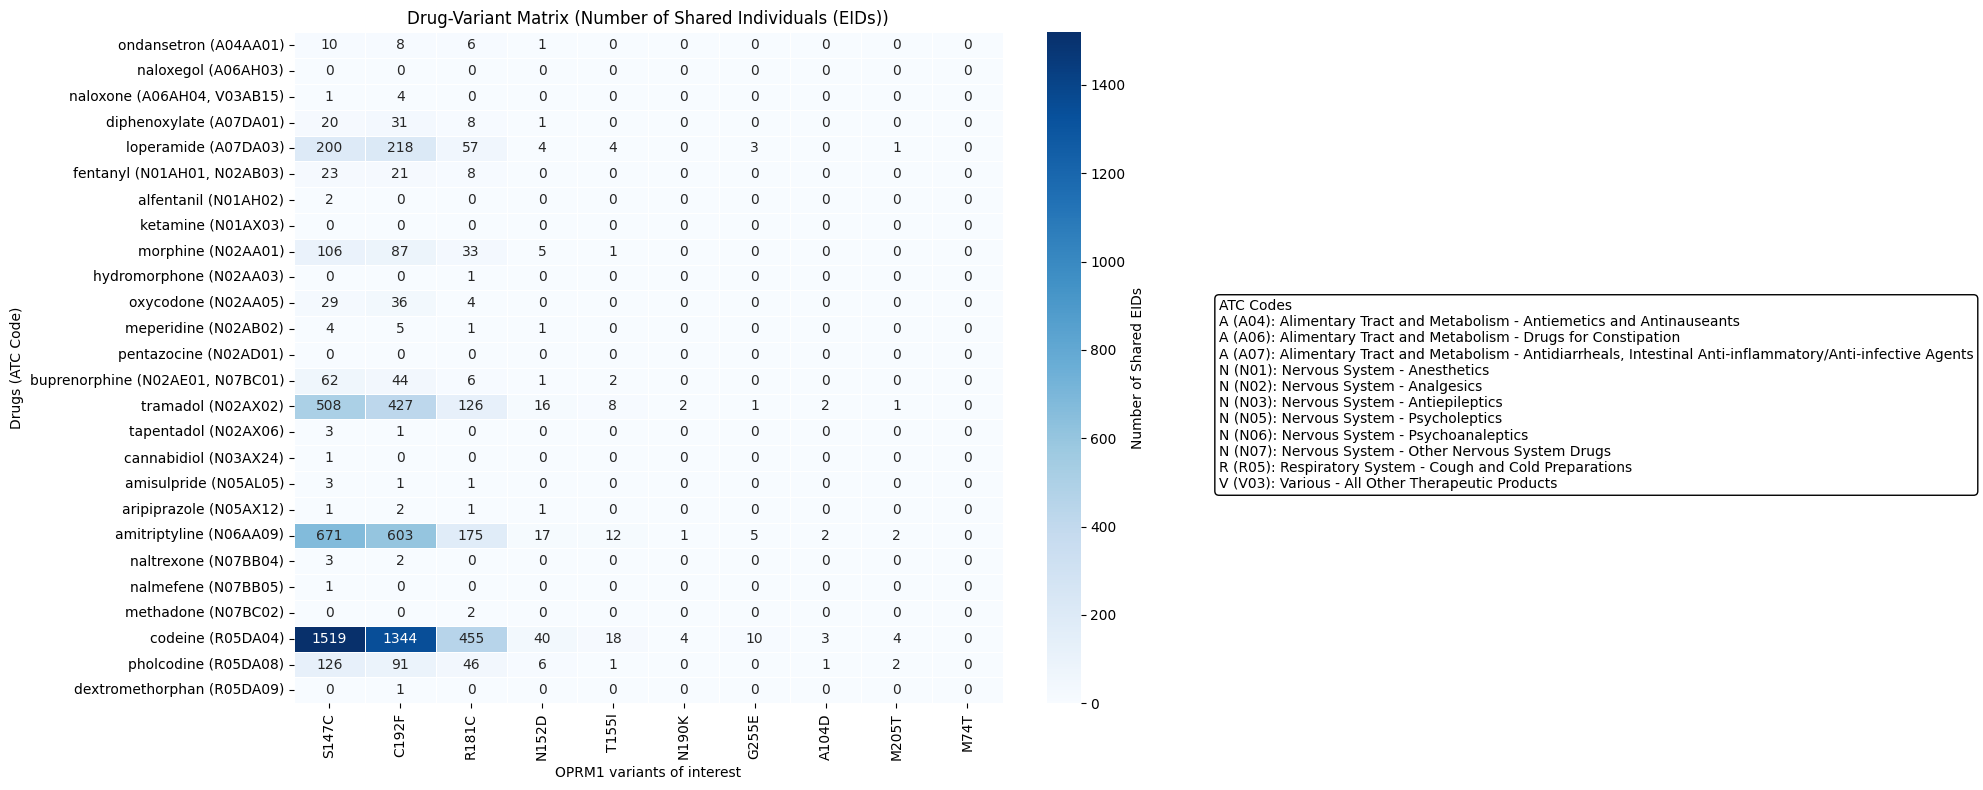

In [ ]:
# Extract drug and variant lists
drugs = drug_eid_df["Drug"].tolist()
variants = variant_eid_df_filtered["Annotation"].tolist()

# Create a mapping of drugs to their ATC codes
drug_atc_mapping = (
    filtered_df_ATC.groupby("concept_name")["ATC"]
    .apply(lambda x: ", ".join(sorted(x.unique())))
    .to_dict()
)

# Order drugs based on ATC code
ordered_drugs = sorted(drugs, key=lambda drug: drug_atc_mapping.get(drug, "ZZZ"))

# Create a mapping of ATC First and Second Level codes to their meanings
atc_legend = filtered_df_ATC[
    ["ATC_First_Level", "First_Level_Name", "ATC_Second_Level", "Second_Level_Name"]
].drop_duplicates()
atc_legend = atc_legend.sort_values(
    by=["First_Level_Name", "ATC_First_Level", "ATC_Second_Level"],
    ascending=[True, True, True],
)
atc_legend_text = "\n".join(
    [
        f"{row['ATC_First_Level']} ({row['ATC_Second_Level']}): {row['First_Level_Name']} - {row['Second_Level_Name']}"
        for _, row in atc_legend.iterrows()
    ]
)

# Add ATC codes to the drug names
ordered_drug_labels = [
    f"{drug} ({drug_atc_mapping.get(drug, 'N/A')})" for drug in ordered_drugs
]

# Create an empty matrix to store EID counts
matrix = np.zeros((len(ordered_drugs), len(variants)))

# Fill the matrix with the count of shared EIDs
for i, drug in enumerate(ordered_drugs):
    drug_eids = set(
        drug_eid_df.loc[drug_eid_df["Drug"] == drug, "EIDs"].values[0]
    )  # Get EIDs for the drug
    for j, variant in enumerate(variants):
        variant_eids = set(
            variant_eid_df_filtered.loc[
                variant_eid_df_filtered["Annotation"] == variant, "EIDs"
            ].values[0]
        )  # Get EIDs for the variant
        shared_eids = drug_eids.intersection(variant_eids)  # Find overlapping EIDs
        matrix[i, j] = len(shared_eids)  # Store the count in the matrix

# Create a DataFrame for visualization
heatmap_df = pd.DataFrame(matrix, index=ordered_drug_labels, columns=variants)

# Plot the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={"label": "Number of Shared EIDs"},
)

# Customize labels
plt.xlabel("OPRM1 variants of interest")
plt.ylabel("Drugs (ATC Code)")
plt.title("Drug-Variant Matrix (Number of Shared Individuals (EIDs))")
plt.xticks(rotation=90)  # Rotate variant labels for readability
plt.yticks(rotation=0)

# Create a legend for ATC codes
plt.figtext(
    1.02,
    0.5,
    "ATC Codes\n" + atc_legend_text,
    wrap=True,
    fontsize=10,
    verticalalignment="center",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
)

# Save the plot
plt.tight_layout()
plt.savefig("drug_variant_heatmap.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

Now we want to fletch the histogram of drug usage onto the left of the matrix

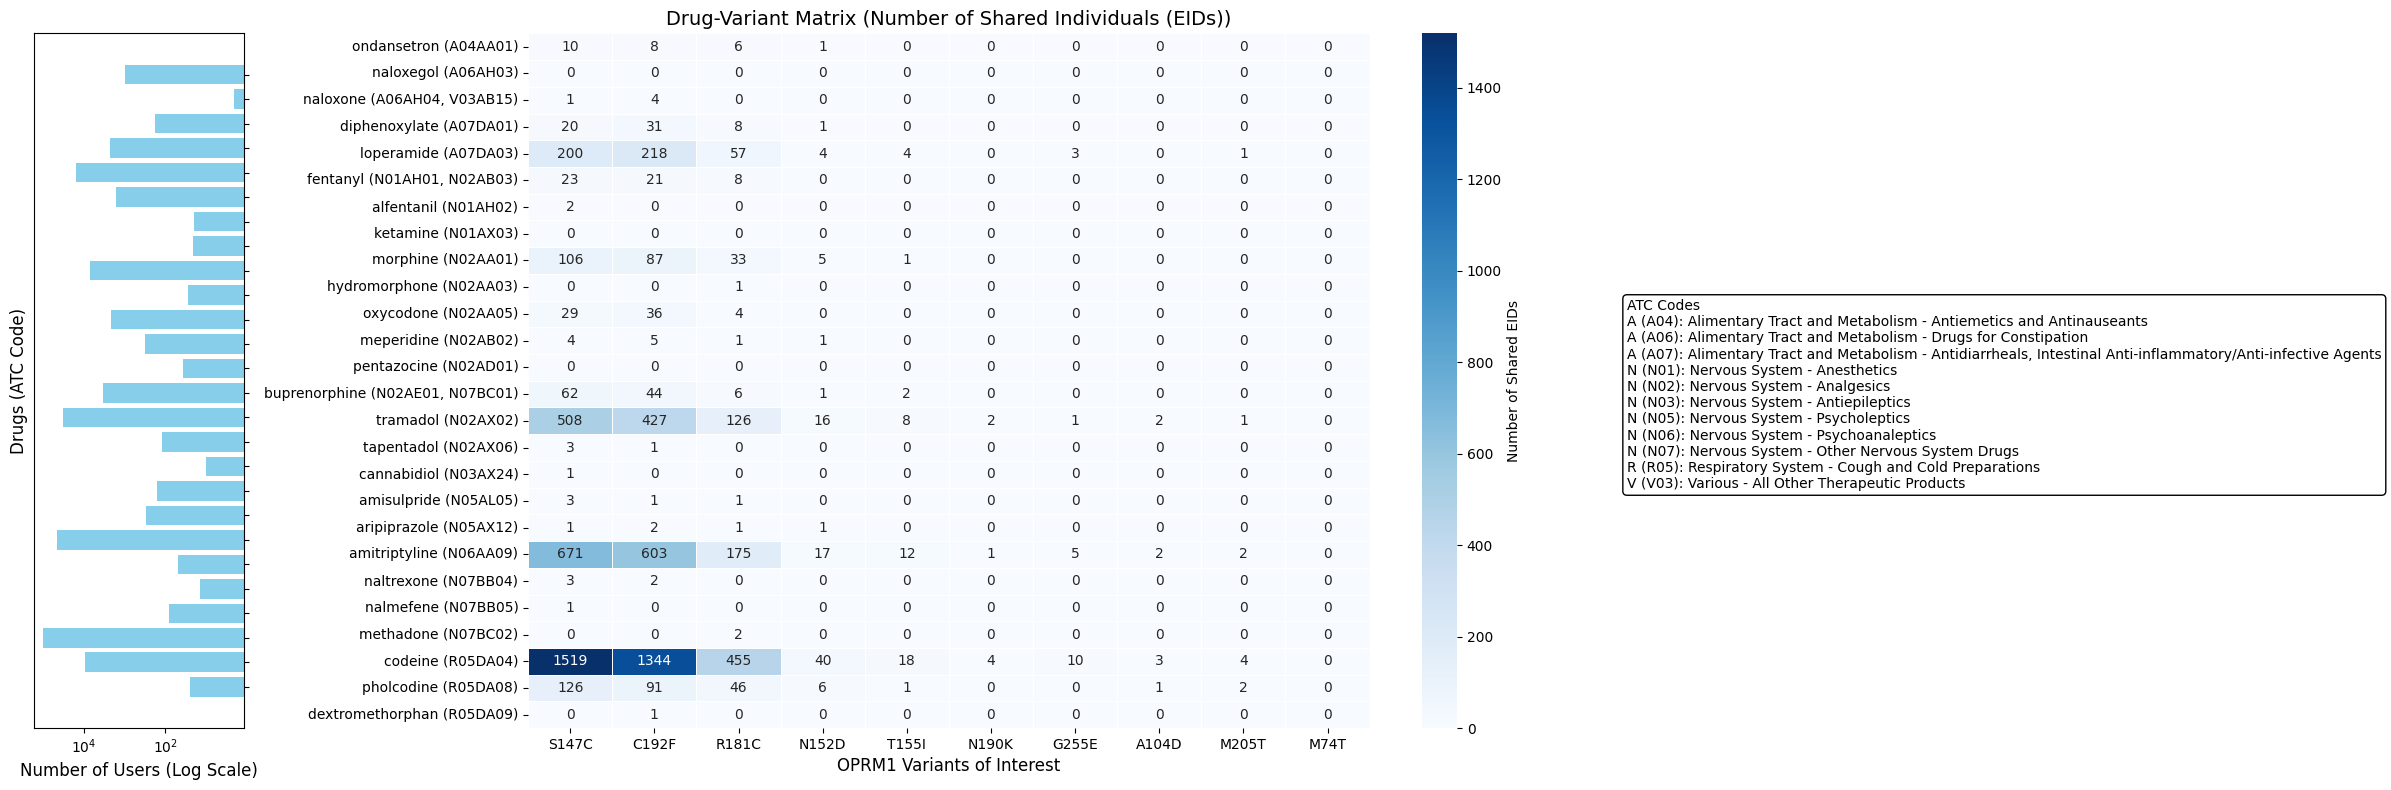

In [ ]:
# Ensure drug_counts follows the same order as ordered_drugs
drug_counts_dict = drug_counts.set_index("drug")["count"].to_dict()
ordered_drug_counts = [
    drug_counts_dict.get(drug, 0) for drug in ordered_drugs
]  # Get count, default to 0 if missing

# Create the figure with three sections: bar chart, heatmap, and legend
fig, axes = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={"width_ratios": [1.2, 6]})

# ----- LEFT PLOT: BAR CHART -----
axes[0].barh(
    ordered_drug_labels, ordered_drug_counts, color="skyblue", align="center"
)  # Use ordered labels
axes[0].set_xscale("log")  # Log scale for better visualization
axes[0].set_xlabel("Number of Users (Log Scale)", fontsize=12)
axes[0].set_ylabel("Drugs (ATC Code)", fontsize=12)
axes[0].invert_xaxis()
axes[0].invert_yaxis()

# Hide y-axis labels for the left plot
axes[0].tick_params(
    axis="y", labelleft=False, right=True, left=False
)  # Hide y-tick labels


# ----- RIGHT PLOT: HEATMAP -----
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={"label": "Number of Shared EIDs"},
    ax=axes[1],
)

# Customize labels
axes[1].set_xlabel("OPRM1 Variants of Interest", fontsize=12)
axes[1].set_ylabel("")  # Hide y-axis label
axes[1].set_title(
    "Drug-Variant Matrix (Number of Shared Individuals (EIDs))", fontsize=14
)
axes[1].tick_params(axis="y", labelleft=True, rotation=0)  # Hide y-tick labels

# ----- ADD ATC LEGEND -----
atc_legend_text = "\n".join(
    [
        f"{row['ATC_First_Level']} ({row['ATC_Second_Level']}): {row['First_Level_Name']} - {row['Second_Level_Name']}"
        for _, row in atc_legend.iterrows()
    ]
)

plt.figtext(
    1.02,
    0.5,
    "ATC Codes\n" + atc_legend_text,
    wrap=True,
    fontsize=10,
    verticalalignment="center",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
)

# Adjust layout to fit everything nicely
plt.tight_layout()

# Save the plot
plt.savefig("drug_variant_heatmap_with_drug_usage.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

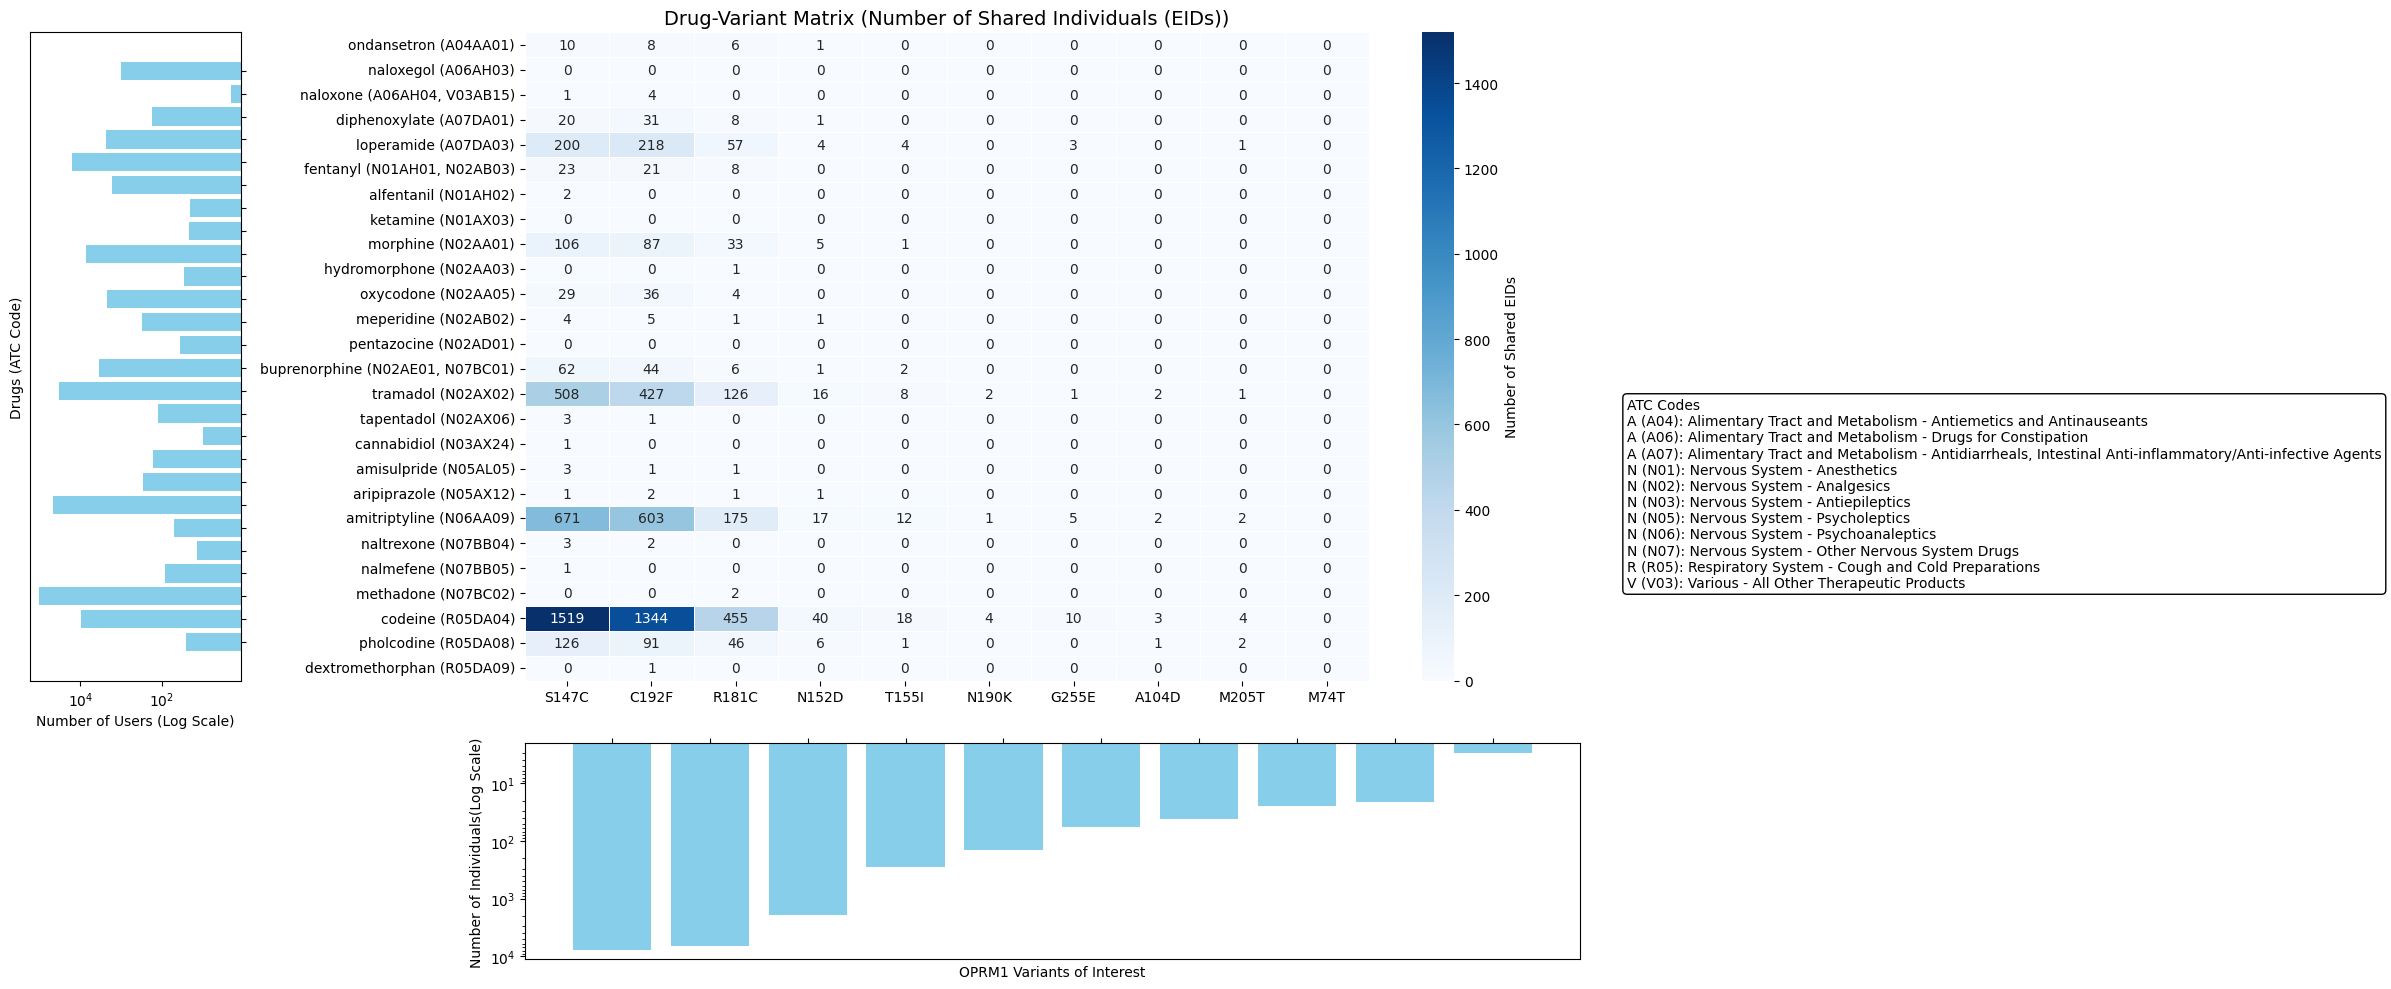

In [ ]:
# Assuming `drug_counts` dataframe exists and ordered_drugs is available
drug_counts_dict = drug_counts.set_index("drug")["count"].to_dict()
ordered_drug_counts = [
    drug_counts_dict.get(drug, 0) for drug in ordered_drugs
]  # Get count, default to 0 if missing

# Create the figure with two rows: vertical histogram, heatmap, and horizontal histogram
fig, axes = plt.subplots(
    2,
    2,
    figsize=(16, 10),
    gridspec_kw={"width_ratios": [1.2, 6], "height_ratios": [6, 2]},
)

# ----- LEFT PLOT: VERTICAL HISTOGRAM (DRUGS) ----
axes[0, 0].barh(
    ordered_drug_labels, ordered_drug_counts, color="skyblue", align="center"
)
axes[0, 0].set_xscale("log")
axes[0, 0].set_xlabel("Number of Users (Log Scale)", fontsize=10)
axes[0, 0].set_ylabel("Drugs (ATC Code)", fontsize=10)
axes[0, 0].invert_xaxis()
axes[0, 0].invert_yaxis()
axes[0, 0].tick_params(
    axis="y", labelleft=False, right=True, left=False
)  # Hide y-tick labels

# ----- RIGHT PLOT: HEATMAP ----
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={"label": "Number of Shared EIDs"},
    ax=axes[0, 1],
)

axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")  # Hide y-axis label
axes[0, 1].set_title(
    "Drug-Variant Matrix (Number of Shared Individuals (EIDs))", fontsize=14
)
axes[0, 1].tick_params(axis="y", labelleft=True, rotation=0)  # Rotate y-tick labels

# ----- BOTTOM PLOT: HORIZONTAL HISTOGRAM (VARIANTS) ----
axes[1, 1].bar(
    variant_eid_df_filtered["Annotation"],
    variant_eid_df_filtered["Num_Individuals"],
    color="skyblue",
    align="center",
)
axes[1, 1].set_ylabel("Number of Individuals(Log Scale)", fontsize=10)
axes[1, 1].set_yscale("log")
axes[1, 1].set_xlabel("OPRM1 Variants of Interest", fontsize=10)
axes[1, 1].invert_yaxis()
axes[1, 1].tick_params(axis="x", labelbottom=False, top=True, bottom=False)

# Hide the empty bottom-left subplot
axes[1, 0].axis("off")

# ----- ADD ATC LEGEND -----
atc_legend_text = "\n".join(
    [
        f"{row['ATC_First_Level']} ({row['ATC_Second_Level']}): {row['First_Level_Name']} - {row['Second_Level_Name']}"
        for _, row in atc_legend.iterrows()
    ]
)

plt.figtext(
    1.02,
    0.5,
    "ATC Codes\n" + atc_legend_text,
    wrap=True,
    fontsize=10,
    verticalalignment="center",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
)

# Adjust layout to fit everything nicely
plt.tight_layout()

# Save the plot
plt.savefig("drug_variant_heatmap_with_drug_usage.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()